$\textbf{GOAL}$ : Plot a heatmap like Dohono Tanner did to see phase transition of a particular model.

In [ ]:
using Plots, LaTeXStrings, Printf, LinearAlgebra, Statistics, Random
using JLD2, FileIO

In [ ]:

# data = load("hm_res_nu01_no_warm.jld2")

# pesr_r1 = data["pesr_r"]
# f1_r_s1   = data["f1_r"]
# fdr_r1  = data["fdr_r"]
# tpr_r1 = data["tpr_r"]

# println(size(pesr_r1))
# println(pesr_r1)

(20, 31)
[1.0 1.0 1.0 1.0 1.0 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN; 0.95 1.0 1.0 1.0 0.95 1.0 1.0 1.0 1.0 1.0 0.95 0.9 0.75 0.7 0.5 0.3 0.35 0.35 0.15 0.1 0.05 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.95 0.95 0.95 0.9 0.95 0.95 0.95 1.0 1.0 0.95 0.85 0.8 0.6 0.55 0.25 0.15 0.1 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.85 0.75 0.4 0.4 0.25 0.05 0.1 0.05 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.95 0.95 0.9 0.95 1.0 1.0 1.0 1.0 0.9 0.85 0.75 0.55 0.35 0.25 0.05 0.05 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 1.0 1.0 0.95 0.95 0.95 0.9 0.8 0.8 0.65 0.4 0.35 0.45 0.2 0.1 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.95 0.95 1.0 1.0 1.0 1.0 1.0 0.9 0.7 0.65 0.65 0.5 0.3 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 1.0 0.95 0.95 1.0 1.0 0.95 0.8 0.7 0.55 0.35 0.4 0.2 0.2 0.0 

In [2]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

In [3]:
function phase_transition_lmbd_warm(n,p,s,ista_method, λ_sel; σ=0.1, B=20, seed=42, isWarm=false)
    Random.seed!(seed)

    acc_pesr=acc_f1=acc_fdr=acc_tpr=0.0
    for _ in 1:B
        X = randn(n,p)
        X .-= mean(X;dims=1)
        X ./= std(X;dims=1)

        β = zeros(p)
        β[randperm(p)[1:s]] .= 3

        y = X*β + σ*randn(n)
        λ = λ_sel(X)
        
        β_hat= ista_method(X, y, λ; isWarm=isWarm)
        
        y, ŷ = abs.(β) .> 0, abs.(β_hat) .> 0

        acc_pesr += pesr(β, β_hat; tol=0)
        acc_f1 += f1score(y, ŷ)
        acc_fdr += fdr(y, ŷ)
        acc_tpr += tpr(y, ŷ)
    end
    pesr_r = acc_pesr/B
    f1_r = acc_f1 /B
    fdr_r = acc_fdr/B
    tpr_r = acc_tpr/B

    return pesr_r,f1_r,fdr_r,tpr_r
end


phase_transition_lmbd_warm (generic function with 1 method)

In [4]:
function data_hm_transition_model(transition_model, ista_method, λ_sel;
    n=50, p_vals=round.(Int, range(20, 500, length = 10)), s_vals =collect(0:20)
)
    ratios   = p_vals ./ n 

    PESR = zeros(length(ratios), length(s_vals))
    F1   = similar(PESR)
    FDR = similar(PESR)
    TPR = similar(PESR)

    @printf "Running %d × %d grid …\n" length(ratios) length(s_vals)
    for (j, p) in enumerate(p_vals)
        for (i, s) in enumerate(s_vals)
            if p<s
                # NaN
                PESR[j, i] = NaN
                F1[j, i] = NaN
                FDR[j, i] = NaN
                TPR[j, i] = NaN
                
                println("Skipping p = $p < s = $s")
                continue
            end

            pesr_r, f1_r, fdr_r, tpr_r = transition_model(n, p, s, ista_method, λ_sel; isWarm = false)
            PESR[j, i] = pesr_r
            F1[j,  i] = f1_r
            FDR[j, i] = fdr_r
            TPR[j, i] = tpr_r
        end
        println("iteration $j / $(length(p_vals)) done - PESR $(PESR[j,:])")
    end

    return PESR, F1, FDR, TPR
end

data_hm_transition_model (generic function with 1 method)

In [5]:
using ColorSchemes

# TODO : faire une meilleure gestion des NaN pour y mettre une belle couleur (et pas voir la grille en arrière ni un blanc moche)
# Actuellement ca focntionne mais un peu trop : tous les 0 (il semblerait) son confondus avec les NaN...

function _prep_nan(z; cmap_name = :magma, nan_col = :cyan)
    finite = filter(!isnan, vec(z))
    Δ      = maximum(finite) - minimum(finite)
    sent   = maximum(finite) + Δ          # off‑scale sentinel
    Zsent  = replace(z, NaN => sent)

    base   = ColorSchemes.colorschemes[cmap_name].colors
    cmap   = cgrad([nan_col; base],
                   [0; range(1, length = length(base))] ./ length(base))

    clims  = extrema(finite)
    return Zsent, cmap, clims
end

function _hm(z, s_list, p_vals, ttl; cmap_name = :magma, nan_col = :cyan)
    Z, cmap, clims = _prep_nan(z; cmap_name = cmap_name, nan_col = nan_col)
    heatmap(s_list, p_vals, Z;c = cmap,clims= clims,xlabel = "s",ylabel = "p/n",title  = ttl)
end

function display_hms(pesr_r, f1_r, fdr_r, tpr_r, s_list, p_vals;title = "Title",cmap_name = :magma,nan_col= :cyan)

    # p1 = _hm(pesr_r, s_list, p_vals, "PESR";   cmap_name, nan_col)
    # p2 = _hm(f1_r,   s_list, p_vals, "F1 Score"; cmap_name, nan_col)
    # p3 = _hm(fdr_r,  s_list, p_vals, "FDR";    cmap_name, nan_col)
    # p4 = _hm(tpr_r,  s_list, p_vals, "TPR";    cmap_name, nan_col)

    p1=heatmap(s_list, p_vals./n, pesr_r, xlabel="s", ylabel="p/n", title="PESR")
    p2=heatmap(s_list, p_vals./n, f1_r, xlabel="s", ylabel="p/n", title="F1 Score")
    p3=heatmap(s_list, p_vals./n, fdr_r, xlabel="s", ylabel="p/n", title="FDR")
    p4=heatmap(s_list, p_vals./n, tpr_r, xlabel="s", ylabel="p/n", title="TPR")


    plot(p1, p2, p3, p4; layout = (2, 2), size = (900, 800),plot_title = title)
end

display_hms (generic function with 1 method)

In [6]:
n = 50
# still have p>s because we need for experiments at least s variable useful
p_vals = round.(Int, range(5, 500, length = 20))
s_vals = collect(0:30)
;

# Linear model, RMSE + $\lambda ||\cdot||$ *(lin_q1_l1)*

## Setup

## Simulations

# Linear model, RMSE + $\lambda P_\nu$ *(lin_q1_nu)*

## Setup

In [7]:
λ_local(y, X) = maximum(abs.(X'*(y .- mean(y)))) / norm(y .- mean(y))
λ_QUT(X; α=0.05, M=1_000) = quantile!([λ_local(randn(size(X,1)), X) for _ in 1:M], 1-α)

λ_QUT (generic function with 1 method)

In [8]:
rho(x, ν)  = abs(x) / (1 + abs(x)^(1-ν))
rho_prime(x, ν) = (1 + ν*abs(x)^(1-ν)) / (1 + abs(x)^(1-ν))^2 

rho_prime (generic function with 1 method)

In [9]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # TODO : attention ! special pour ce cas et se rappeler pourquoi
    while f(a)*f(b)>0
        b*=2
        if b> 1e10
            return a, -1
        end
        
    end
    # @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

In [10]:
function kappa_phi(Γ::Float64, ν::Float64)
    T = eps(Float64)
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1) 
    κ, it = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)), verbose=false)
    φ = κ/2 +  Γ/(1 + κ^(1-ν))

    return κ, φ
end

kappa_phi (generic function with 1 method)

In [11]:
function x_tar(z::Float64, Γ::Float64, ν::Float64, κ::Float64)
    h(x) = x + Γ * rho_prime(x, ν) - z
    res, _ = bisection(h,κ,z; tol = 1e-10, verbose=false)
    return res
end

x_tar (generic function with 1 method)

In [12]:
function prox_harder_vec(z::AbstractVector, γ::Float64, λ::Float64, ν::Float64)
    if ν== 1.0 
        return sign.(z) .* max.(abs.(z) .- γ * λ*0.5, 0.0) # soft thresholding (see l_qut_1) # TODO page 4 harderLASSO pdf phi_1 (confirmer)
    end
    # else proximal operator for harder penalty
    Γ = γ * λ 
    κ, φ = kappa_phi(Γ, ν)    

    β_new = map(z[1:end-1]) do zi # coordinate loop
        abs(zi) ≤ φ - eps() ? 0.0 : sign(zi) * x_tar(abs(zi), Γ, ν, κ) 
    end
    return vcat(β_new, z[end])
end


prox_harder_vec (generic function with 1 method)

In [13]:
function ista_lin_q1_nu(X, y, λ; ν=0.1, tol=1e-8, max_iter=10_000, isWarm=false, warmIter=5, tol_warm=1e-6, max_iter_warm=1_000)
    n,p = size(X)
    X̃ = hcat(X, ones(n))
    f(θ)  = norm(y - X̃*θ)
    ∇f(θ) = X̃'*(X̃*θ - y)/norm(X̃*θ - y)
    θ = zeros(p+1)
    L0 = 1e-4
    
    if isWarm
        λ_path = exp.(range(log(λ/100), log(λ), length = warmIter))
        ν_path = range(1.0, ν,  length = warmIter)

        for (λ_warm, ν_warm) in zip(λ_path, ν_path)
            prox = (z, γ) -> prox_harder_vec(z, γ, λ_warm, ν_warm)
            θ = ista(θ, f, z -> λ_warm * sum(rho.(z[1:end-1], ν_warm)), ∇f, L0, prox; max_iter = max_iter_warm, tol = tol_warm, verbose = false)
        end
    end

    prox = (z,γ) -> prox_harder_vec(z, γ, λ, ν)
    θ = ista(θ, f, z->λ*sum(rho.(z[1:end-1],ν)), ∇f, L0, prox; max_iter=max_iter, tol=tol, verbose=false)
    return θ[1:p]
end

ista_lin_q1_nu (generic function with 1 method)

## Simulations

### No warm, $\nu=0.1$

In [14]:
ν = 0.1

0.1

In [15]:
pesr_r, f1_r, fdr_r, tpr_r = data_hm_transition_model(
    phase_transition_lmbd_warm,
    (X,y,λ; isWarm=false) -> ista_lin_q1_nu(X, y, λ; isWarm=isWarm, ν=ν),
    (X) -> λ_QUT(X);
    n=n, p_vals=p_vals, s_vals=s_vals
)

Running 20 × 31 grid …
Skipping p = 5 < s = 6
Skipping p = 5 < s = 7
Skipping p = 5 < s = 8
Skipping p = 5 < s = 9
Skipping p = 5 < s = 10
Skipping p = 5 < s = 11
Skipping p = 5 < s = 12
Skipping p = 5 < s = 13
Skipping p = 5 < s = 14
Skipping p = 5 < s = 15
Skipping p = 5 < s = 16
Skipping p = 5 < s = 17
Skipping p = 5 < s = 18
Skipping p = 5 < s = 19
Skipping p = 5 < s = 20
Skipping p = 5 < s = 21
Skipping p = 5 < s = 22
Skipping p = 5 < s = 23
Skipping p = 5 < s = 24
Skipping p = 5 < s = 25
Skipping p = 5 < s = 26
Skipping p = 5 < s = 27
Skipping p = 5 < s = 28
Skipping p = 5 < s = 29
Skipping p = 5 < s = 30
iteration 1 / 20 done - PESR [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
iteration 2 / 20 done - PESR [0.95, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.9, 0.75, 0.7, 0.5, 0.3, 0.35, 0.35, 0.15, 0.1, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
it

([1.0 1.0 … NaN NaN; 0.95 1.0 … 0.0 0.0; … ; 1.0 1.0 … 0.0 0.0; 0.8 0.75 … 0.0 0.0], [0.0 1.0 … NaN NaN; 0.0 1.0 … 0.5267790789092698 0.5259593746353755; … ; 0.0 1.0 … 0.21389761740878832 0.1820616288682702; 0.0 0.9166666666666666 … 0.13911988196765562 0.1463973401234233], [0.0 0.0 … NaN NaN; 0.05 0.0 … 0.011584249084249085 0.008712121212121213; … ; 0.0 0.0 … 0.6409207540825188 0.6842131479631479; 0.2 0.125 … 0.7362843406593407 0.7280373792873793], [0.0 1.0 … NaN NaN; 0.0 1.0 … 0.3620689655172414 0.36; … ; 0.0 1.0 … 0.15517241379310343 0.12999999999999998; 0.0 1.0 … 0.09827586206896552 0.10333333333333336])

In [ ]:
filename = "hm_res_nu01_no_warm.jld2"

save(filename, "pesr_r", pesr_r, "f1_r", f1_r, "fdr_r", fdr_r, "tpr_r", tpr_r)
println("Variables saved to $filename")

Variables saved to hm_res_nu01_no_warm.jld2


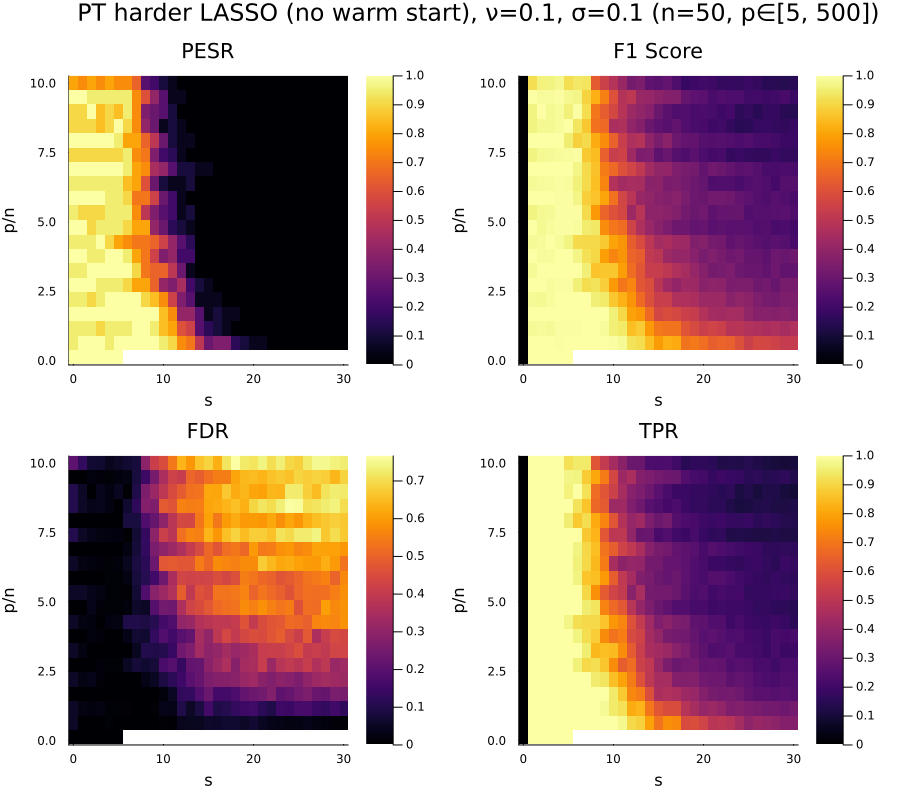

In [64]:
title= "PT harder LASSO (no warm start), ν=$ν, σ=0.1 (n=$n, p∈[$(minimum(p_vals)), $(maximum(p_vals))])"
display_hms(pesr_r, f1_r, fdr_r, tpr_r, s_vals, p_vals; title=title, cmap_name = :magma, nan_col = :cyan)

In [65]:
savefig(title * ".png")

"c:\\Users\\Le R\\Desktop\\Code\\Projets\\Geneve\\STAGE-GENEVE\\RAPHAEL\\notebook_explain\\PT harder LASSO (no warm start), ν=0.1, σ=0.1 (n=50, p∈[5, 500]).png"

### Warm, $\nu=0.1$

In [18]:
ν = 0.1

0.1

In [19]:
pesr_r, f1_r, fdr_r, tpr_r = data_hm_transition_model(
    phase_transition_lmbd_warm,
    (X,y,λ; isWarm=true) -> ista_lin_q1_nu(X, y, λ; isWarm=true, ν=ν),
    (X) -> λ_QUT(X);
    n=n, p_vals=p_vals, s_vals=s_vals
)

Running 20 × 31 grid …
Skipping p = 5 < s = 6
Skipping p = 5 < s = 7
Skipping p = 5 < s = 8
Skipping p = 5 < s = 9
Skipping p = 5 < s = 10
Skipping p = 5 < s = 11
Skipping p = 5 < s = 12
Skipping p = 5 < s = 13
Skipping p = 5 < s = 14
Skipping p = 5 < s = 15
Skipping p = 5 < s = 16
Skipping p = 5 < s = 17
Skipping p = 5 < s = 18
Skipping p = 5 < s = 19
Skipping p = 5 < s = 20
Skipping p = 5 < s = 21
Skipping p = 5 < s = 22
Skipping p = 5 < s = 23
Skipping p = 5 < s = 24
Skipping p = 5 < s = 25
Skipping p = 5 < s = 26
Skipping p = 5 < s = 27
Skipping p = 5 < s = 28
Skipping p = 5 < s = 29
Skipping p = 5 < s = 30
iteration 1 / 20 done - PESR [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
iteration 2 / 20 done - PESR [0.95, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.95, 0.9, 0.95, 0.95, 0.95, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.95, 1.0, 1.0, 1.

([1.0 1.0 … NaN NaN; 0.95 1.0 … 1.0 1.0; … ; 1.0 1.0 … 0.0 0.0; 0.8 0.75 … 0.0 0.0], [0.0 1.0 … NaN NaN; 0.0 1.0 … 1.0 1.0; … ; 0.0 1.0 … 0.17240295680948872 0.2155600220274574; 0.0 0.9166666666666666 … 0.17124924418723114 0.154455924127948], [0.0 0.0 … NaN NaN; 0.05 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.7353106067908699 0.6902728834595506; 0.2 0.125 … 0.7264429211139738 0.7401476516259798], [0.0 1.0 … NaN NaN; 0.0 1.0 … 1.0 1.0; … ; 0.0 1.0 … 0.1293103448275862 0.16666666666666666; 0.0 1.0 … 0.12586206896551727 0.11166666666666666])

In [20]:
filename = "hm_res_nu01_warm.jld2"

save(filename, "pesr_r", pesr_r, "f1_r", f1_r, "fdr_r", fdr_r, "tpr_r", tpr_r)
println("Variables saved to $filename")

Variables saved to hm_res_nu01_warm.jld2


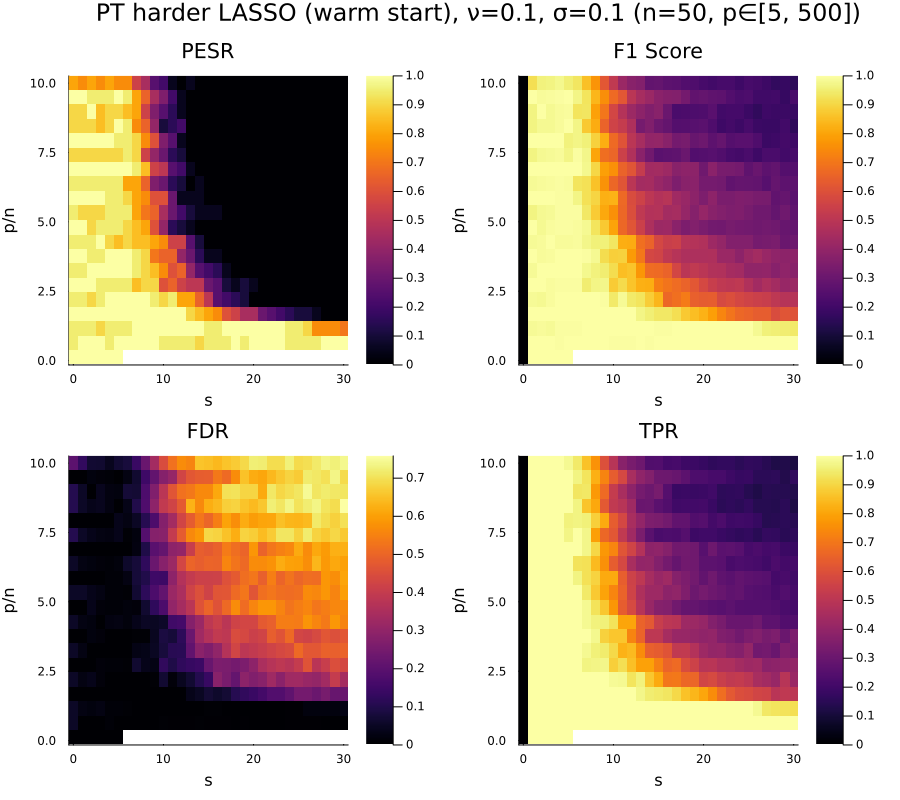

In [80]:
title= "PT harder LASSO (warm start), ν=$ν, σ=0.1 (n=$n, p∈[$(minimum(p_vals)), $(maximum(p_vals))])"
display_hms(pesr_r, f1_r, fdr_r, tpr_r, s_vals, p_vals; title=title, cmap_name = :magma, nan_col = :cyan)

In [81]:
savefig(title * ".png")

"c:\\Users\\Le R\\Desktop\\Code\\Projets\\Geneve\\STAGE-GENEVE\\RAPHAEL\\notebook_explain\\PT harder LASSO (warm start), ν=0.1, σ=0.1 (n=50, p∈[5, 500]).png"

### No warm, $\nu=0.9$

In [21]:
ν = 0.9

0.9

In [22]:
pesr_r, f1_r, fdr_r, tpr_r = data_hm_transition_model(
    phase_transition_lmbd_warm,
    (X,y,λ; isWarm=false) -> ista_lin_q1_nu(X, y, λ; isWarm=false, ν=ν),
    (X) -> λ_QUT(X);
    n=n, p_vals=p_vals, s_vals=s_vals
)

Running 20 × 31 grid …
Skipping p = 5 < s = 6
Skipping p = 5 < s = 7
Skipping p = 5 < s = 8
Skipping p = 5 < s = 9
Skipping p = 5 < s = 10
Skipping p = 5 < s = 11
Skipping p = 5 < s = 12
Skipping p = 5 < s = 13
Skipping p = 5 < s = 14
Skipping p = 5 < s = 15
Skipping p = 5 < s = 16
Skipping p = 5 < s = 17
Skipping p = 5 < s = 18
Skipping p = 5 < s = 19
Skipping p = 5 < s = 20
Skipping p = 5 < s = 21
Skipping p = 5 < s = 22
Skipping p = 5 < s = 23
Skipping p = 5 < s = 24
Skipping p = 5 < s = 25
Skipping p = 5 < s = 26
Skipping p = 5 < s = 27
Skipping p = 5 < s = 28
Skipping p = 5 < s = 29
Skipping p = 5 < s = 30
iteration 1 / 20 done - PESR [0.5, 0.65, 0.7, 0.75, 0.95, 1.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
iteration 2 / 20 done - PESR [0.5, 0.55, 0.5, 0.5, 0.5, 0.5, 0.4, 0.6, 0.45, 0.3, 0.4, 0.3, 0.2, 0.3, 0.3, 0.05, 0.15, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
iter

([0.5 0.65 … NaN NaN; 0.5 0.55 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.8749999999999998 … NaN NaN; 0.0 0.8083333333333332 … 0.5870591649505432 0.5796417690123843; … ; 0.0 0.2820548895548895 … 0.26741985527785317 0.24917578407682; 0.0 0.24412809412809416 … 0.21145598261253545 0.2218331435961233], [0.5 0.18333333333333332 … NaN NaN; 0.5 0.265 … 0.015096153846153848 0.00787878787878788; … ; 1.0 0.8318849206349206 … 0.7179467422915939 0.737047494988049; 1.0 0.8595021645021645 … 0.7786953604387815 0.7596912637586011], [0.0 1.0 … NaN NaN; 0.0 1.0 … 0.42241379310344823 0.4133333333333333; … ; 0.0 1.0 … 0.2603448275862069 0.24166666666666664; 0.0 1.0 … 0.20689655172413796 0.20833333333333334])

In [23]:
filename = "hm_res_nu09_no_warm.jld2"

save(filename, "pesr_r", pesr_r, "f1_r", f1_r, "fdr_r", fdr_r, "tpr_r", tpr_r)
println("Variables saved to $filename")

Variables saved to hm_res_nu09_no_warm.jld2


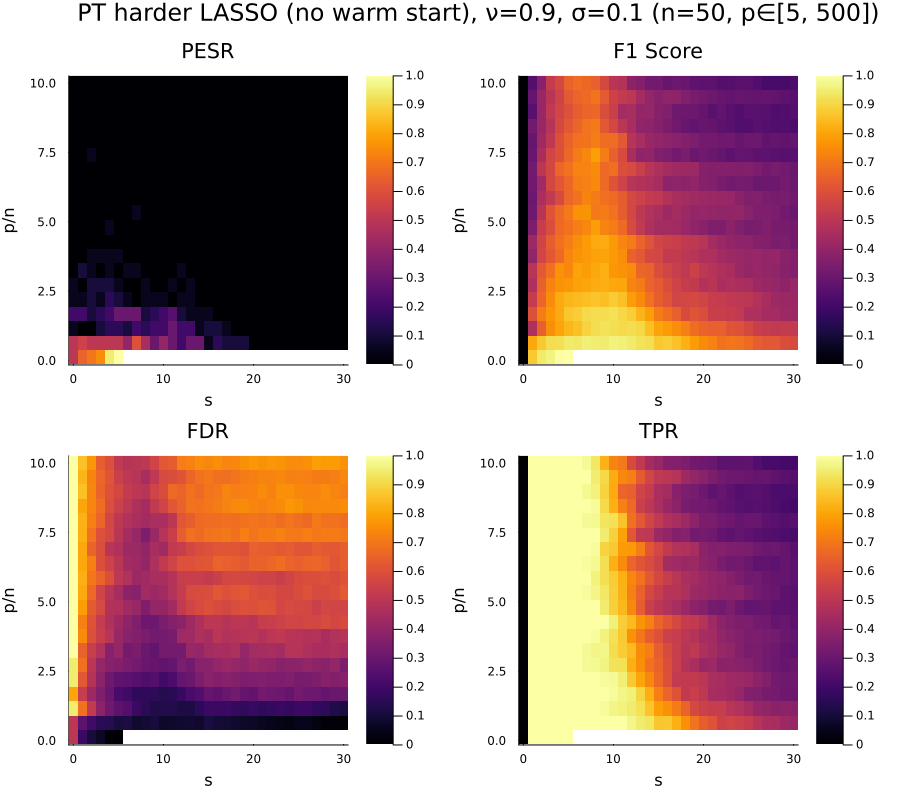

In [90]:
title= "PT harder LASSO (no warm start), ν=$ν, σ=0.1 (n=$n, p∈[$(minimum(p_vals)), $(maximum(p_vals))])"
display_hms(pesr_r, f1_r, fdr_r, tpr_r, s_vals, p_vals; title=title, cmap_name = :magma, nan_col = :cyan)

In [91]:
savefig(title * ".png")

"c:\\Users\\Le R\\Desktop\\Code\\Projets\\Geneve\\STAGE-GENEVE\\RAPHAEL\\notebook_explain\\PT harder LASSO (no warm start), ν=0.9, σ=0.1 (n=50, p∈[5, 500]).png"

### Warm, $\nu=0.9$

In [24]:
ν = 0.9

0.9

In [25]:
pesr_r, f1_r, fdr_r, tpr_r = data_hm_transition_model(
    phase_transition_lmbd_warm,
    (X,y,λ; isWarm=true) -> ista_lin_q1_nu(X, y, λ; isWarm=true, ν=ν),
    (X) -> λ_QUT(X);
    n=n, p_vals=p_vals, s_vals=s_vals
)

Running 20 × 31 grid …
Skipping p = 5 < s = 6
Skipping p = 5 < s = 7
Skipping p = 5 < s = 8
Skipping p = 5 < s = 9
Skipping p = 5 < s = 10
Skipping p = 5 < s = 11
Skipping p = 5 < s = 12
Skipping p = 5 < s = 13
Skipping p = 5 < s = 14
Skipping p = 5 < s = 15
Skipping p = 5 < s = 16
Skipping p = 5 < s = 17
Skipping p = 5 < s = 18
Skipping p = 5 < s = 19
Skipping p = 5 < s = 20
Skipping p = 5 < s = 21
Skipping p = 5 < s = 22
Skipping p = 5 < s = 23
Skipping p = 5 < s = 24
Skipping p = 5 < s = 25
Skipping p = 5 < s = 26
Skipping p = 5 < s = 27
Skipping p = 5 < s = 28
Skipping p = 5 < s = 29
Skipping p = 5 < s = 30
iteration 1 / 20 done - PESR [0.45, 0.6, 0.7, 0.75, 0.95, 1.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
iteration 2 / 20 done - PESR [0.5, 0.6, 0.55, 0.5, 0.5, 0.45, 0.35, 0.6, 0.45, 0.35, 0.4, 0.3, 0.25, 0.3, 0.3, 0.15, 0.2, 0.2, 0.15, 0.1, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

([0.45 0.6 … NaN NaN; 0.5 0.6 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.8583333333333332 … NaN NaN; 0.0 0.8333333333333333 … 0.607250380839002 0.6034933266545214; … ; 0.0 0.28301698301698297 … 0.26335987987372 0.2539443659935748; 0.0 0.2417471417471418 … 0.20658544524319108 0.22067112198829192], [0.55 0.20833333333333334 … NaN NaN; 0.5 0.23166666666666663 … 0.01530448717948718 0.012045454545454545; … ; 1.0 0.8310299422799423 … 0.7292994256164863 0.7341921070204155; 1.0 0.8611688311688314 … 0.7826794591278288 0.7630138034868456], [0.0 1.0 … NaN NaN; 0.0 1.0 … 0.4431034482758621 0.43999999999999995; … ; 0.0 1.0 … 0.26206896551724135 0.24833333333333335; 0.0 1.0 … 0.20172413793103447 0.21000000000000002])

In [26]:
filename = "hm_res_nu09_warm.jld2"

save(filename, "pesr_r", pesr_r, "f1_r", f1_r, "fdr_r", fdr_r, "tpr_r", tpr_r)
println("Variables saved to $filename")

Variables saved to hm_res_nu09_warm.jld2


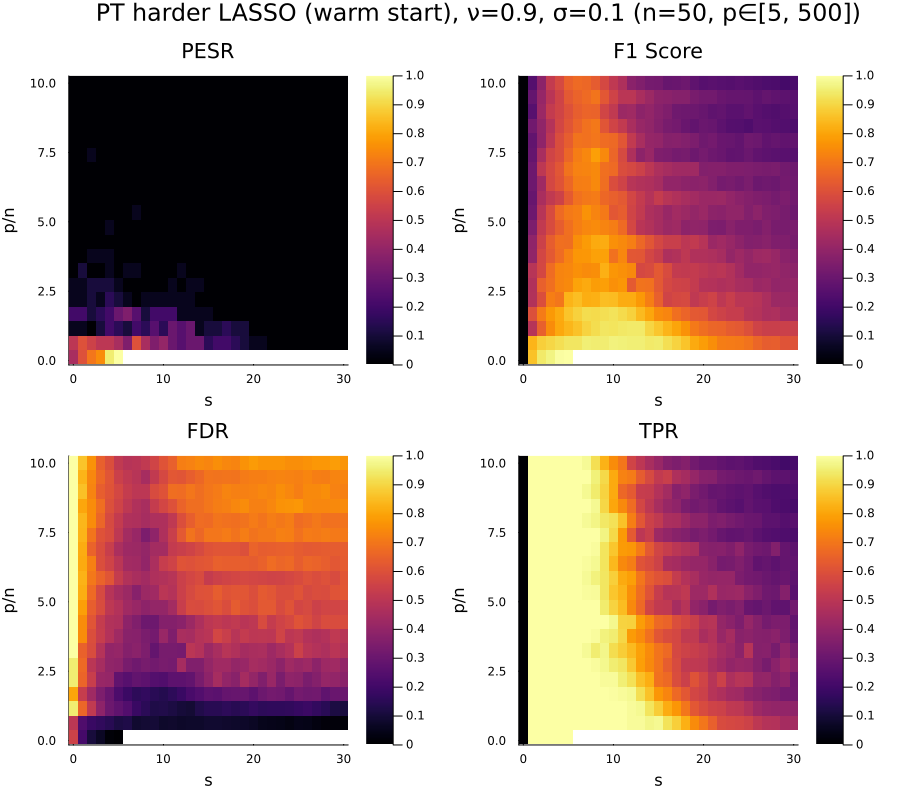

In [86]:
title= "PT harder LASSO (warm start), ν=$ν, σ=0.1 (n=$n, p∈[$(minimum(p_vals)), $(maximum(p_vals))])"
display_hms(pesr_r, f1_r, fdr_r, tpr_r, s_vals, p_vals; title=title, cmap_name = :magma, nan_col = :cyan)

In [87]:
savefig(title * ".png")

"c:\\Users\\Le R\\Desktop\\Code\\Projets\\Geneve\\STAGE-GENEVE\\RAPHAEL\\notebook_explain\\PT harder LASSO (warm start), ν=0.9, σ=0.1 (n=50, p∈[5, 500]).png"

## Plots

In [1]:
using Plots
using JLD2
using Measures
using LaTeXStrings

In [ ]:
datasets = [
    ("hm_res_nu09_no_warm.jld2",  L"ν = 0.9 \ –  \ no \ warm‑start"),
    ("hm_res_nu09_warm.jld2",     L"ν = 0.9 \ –  \ warm‑start"),
    ("hm_res_nu01_no_warm.jld2",  L"ν = 0.1 \ –  \ no \ warm‑start"),
    ("hm_res_nu01_warm.jld2",     L"ν = 0.1 \ –  \ warm‑start")
]

metric_syms   = [:pesr_r, :f1_r, :tpr_r, :fdr_r]  # extraction order
metric_titles = [L"PESR", L"F1", L"TPR", L"FDR"]      # column headings

all_mats = Vector{Vector{Array{<:Real,2}}}(undef, length(datasets))

for (k,(file,_)) in pairs(datasets)
    d = load(file)
    mats = [d[string(s)] for s in metric_syms]
    all_mats[k] = mats
end

row_labels    = [lbl for (_, lbl) in datasets]


4-element Vector{LaTeXString}:
 L"$ν = 0.9 \ –  \ no \ warm‑start$"
 L"$ν = 0.9 \ –  \ warm‑start$"
 L"$ν = 0.1 \ –  \ no \ warm‑start$"
 L"$ν = 0.1 \ –  \ warm‑start$"

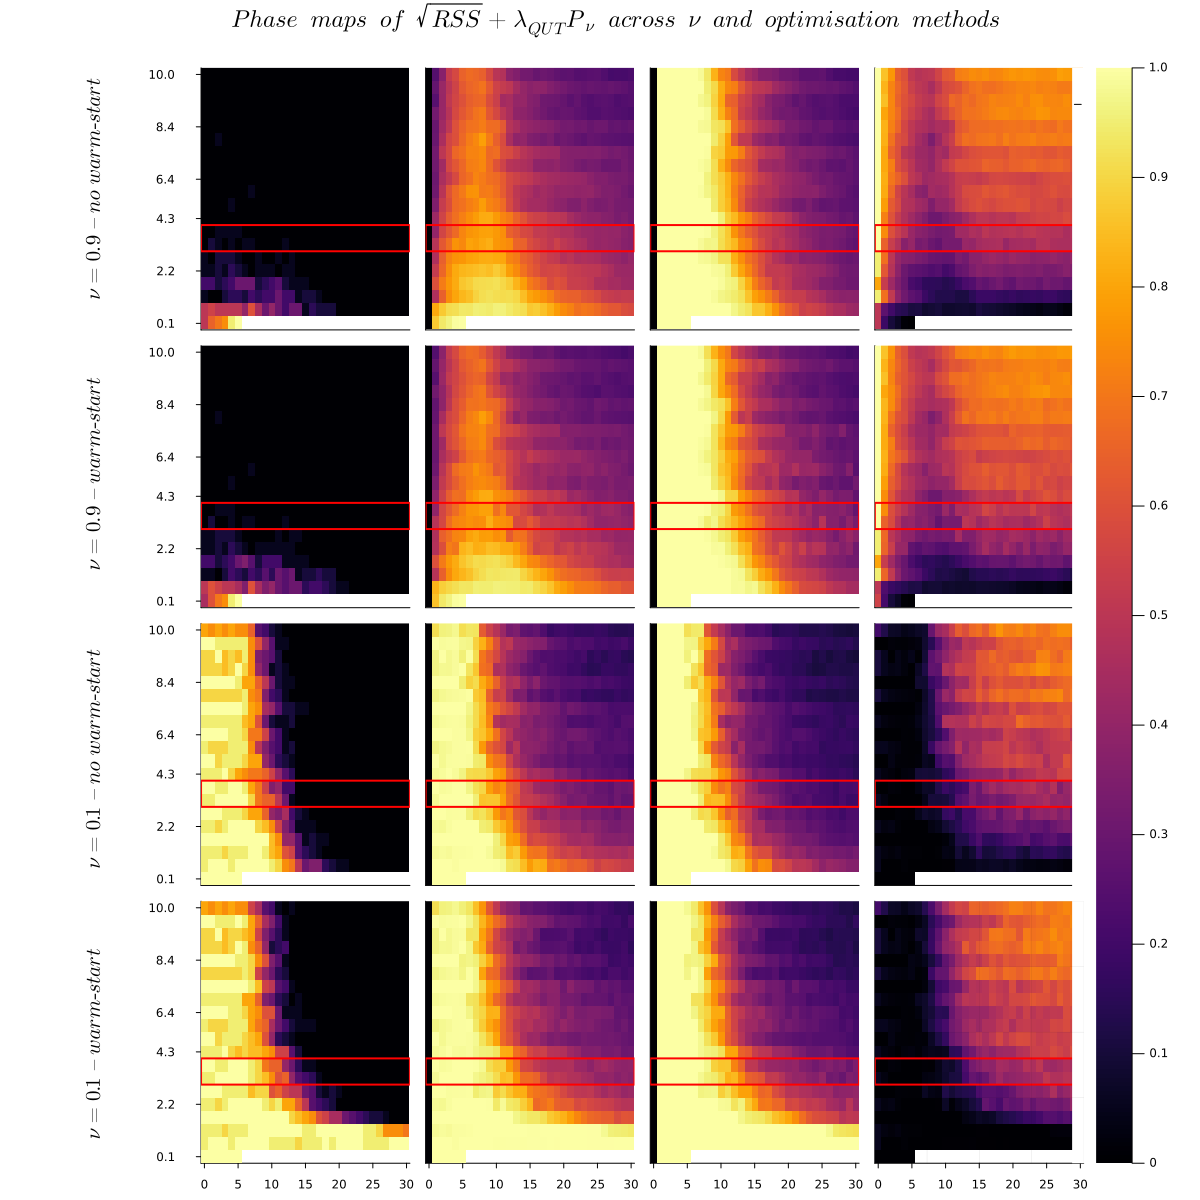

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [60]:
cmin = 0
cmax = 1
n=50
p_vals = round.(range(5, 500, length = 20)./n, digits=1) 
# take one third of p_val
p_vals = vcat(p_vals[1:4:end], 10)  # take one third of p_vals for better visibility

# convert to axis positions --------------------------------------------------
ytick_pos = round.(Int, range(1, size(all_mats[1][1],1), length = length(p_vals)))
# xtick_pos = # je veux que mes xticks_pos soit espacés tous les 5 et que ça compte de 1 à 30 mais genre 0,5,10,...,25,30
s_vals = collect(0:5:30)                                    # x‑axis
xtick_pos = s_vals

# 4×4 grid + narrow colour‑bar
grid_cols  = 6                                # 1(label) + 4(hm) + 1(cb)
layout     = @layout [grid(4,1){0.1w} grid(4,4) cb{0.05w}]
plt        = plot(layout = layout, size = (1200,1200), margin = 0mm,
            plot_title = L"$Phase \ \ maps \ \ of \ \ \sqrt{RSS} + \lambda_{QUT} P_\nu \ \ across \ \ \nu \ \ and  \ \ optimisation \ \ methods$"
    )

row_labels = last.(datasets)

idx_heat(i, j) = 4*(i-1) + j  + 4 # heatmap index in the grid
cb_idx = 21                          # colour-bar (single cell)


# ------------- left-hand row titles ---------------------------------------
for i in 1:4
    plot!(plt, subplot=i, framestyle=:none, axis=false)
    annotate!(plt[i], (0.5,0.5,
        text(row_labels[i], 14, :center, rotation=90)))
end

# ------------- 16 heat-maps -----------------------------------------------
ROW_BOX = 7  
for i in 1:4, j in 1:4
    mat = all_mats[i][j]
    idx  = idx_heat(i,j) 
   nr,nc = size(mat)

    limx  = (0.5, nc + 0.5)           # ← freeze the plot window
    limy  = (0.5, nr + 0.5)

    # ── heat-map ───────────────────────────────────────────────────────────
    heatmap!(plt, mat;
             subplot  = idx,
             clim     = (cmin,cmax),
             colorbar = false,
             left_margin = (j==1 ? 0mm : 0mm),
             xlims = limx, ylims = limy,      # ← NEW
             xticks = (i==4 ? (1:5:nc, s_vals) : false),
             yticks = (j==1 ? (ytick_pos, p_vals) : false),
             xtick_direction=:out, ytick_direction=:out, grid=false)



    ncol      = size(mat, 2)
    xcoords   = [0.5, ncol+0.5, ncol+0.5, 0.5, 0.5]
    ycoords   = [ROW_BOX-0.5, ROW_BOX-0.5, ROW_BOX+1.5,
                 ROW_BOX+1.5, ROW_BOX-0.5]

    plot!(plt, xcoords, ycoords;
          seriestype = :shape,
          linecolor  = :red,
          linewidth  = 2,
          fillalpha  = 0,                # hollow box
          label      = false,
          subplot    = idx)
    end
    
heatmap!(plt, fill(NaN,1,1);
            clim       = (cmin,cmax),
            colorbar   = true,
            xaxis      = false, yaxis = false,
            subplot    = cb_idx)


In [61]:
savefig("heatmaps.svg")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"c:\\Users\\Le R\\Desktop\\Code\\Projets\\Geneve\\STAGE-GENEVE\\RAPHAEL\\notebook_explain\\heatmaps.svg"